In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

from sklearn.model_selection import StratifiedKFold

import imgaug as ia
import imgaug.augmenters as iaa

import torch
from torch.utils.data.dataloader import DataLoader

import fastai
from fastai.vision import *

from optim import Over9000
from data import Bengaliai_DS, Bengaliai_DS_LIT
from model import *
from model_utils import *
from MG_models import LocNCls_Light

---

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [18]:
pdf = pd.read_csv('../input/train.csv')
unique_grapheme = pdf['grapheme'].unique()
grapheme_code = dict([(g, c) for g, c in zip(unique_grapheme, np.arange(unique_grapheme.shape[0]))])
pdf['grapheme_code'] = [grapheme_code[g] for g in pdf['grapheme']]

skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
for trn_ndx, vld_ndx in skf.split(pdf['grapheme_code'], pdf['grapheme_code']):
    break
    
imgs = bp.unpack_ndarray_from_file('../features/train_images_size160_pad8.bloscpack')
lbls = pdf.iloc[:, [1,2,3,5]].values

trn_imgs = imgs[trn_ndx]
trn_lbls = lbls[trn_ndx]
vld_imgs = imgs[vld_ndx]
vld_lbls = lbls[vld_ndx]

In [4]:
augs = iaa.SomeOf(
    (0, 2),
    [
        iaa.SomeOf(
            (1, 2),
            [
                iaa.OneOf(
                    [
                        iaa.Affine(scale={"x": (0.8, 1.), "y": (0.8, 1.)}, rotate=(-15, 15), shear=(-15, 15)),
                        iaa.PerspectiveTransform(scale=.08, keep_size=True),
                    ]
                ),
                iaa.PiecewiseAffine(scale=(0.02, 0.03)),
            ],
            random_order=True
        ),
        iaa.DirectedEdgeDetect(alpha=(.6, .8), direction=(0.0, 1.0)),
    ],
    random_order=True
)


In [19]:
batch_size = 64 # 64 is important as the fit_one_cycle arguments are probably tuned for this batch size

training_set = Bengaliai_DS(trn_imgs, trn_lbls, transform=augs)
validation_set = Bengaliai_DS(vld_imgs, vld_lbls)

training_loader = DataLoader(training_set, batch_size=batch_size, num_workers=6, shuffle=True) # , sampler=sampler , shuffle=True
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=6, shuffle=False)

data_bunch = DataBunch(train_dl=training_loader, valid_dl=validation_loader)

---
### model

In [6]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

predictor = PretrainedCNN(out_dim=n_total)
base_model = BengaliClassifier(predictor)

base_model_weight = torch.load('./outputs/Seresnext50_Size160_Augs_CmMu.pth')
base_model.load_state_dict(base_model_weight)

<All keys matched successfully>

In [22]:
test = torch.nn.Sequential(*([nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, bias=True)] + list(base_model.predictor.base_model.children())[:-2]))

In [20]:
for a, b in training_loader:
    break

In [24]:
c = test(a)

In [25]:
c.shape

torch.Size([64, 2048, 5, 5])

In [6]:
device = 'cuda:0'

In [7]:
classifier = LocNCls_Light(n_base=1295, n_grapheme=168, n_vowel=11, n_consonant=7).to(device)

In [10]:
for a, b in training_loader:
    break

In [13]:
a.shape

torch.Size([64, 1, 168, 168])

In [14]:
a_np = a.numpy()

In [15]:
a_np = a_np * 0.2051 + 0.0692

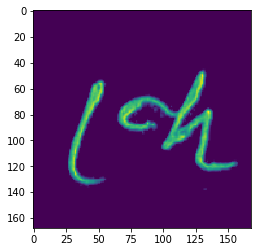

In [21]:
plt.imshow(a_np[2, 0])

In [24]:
b = classifier.stn(classifier.adapter(a.cuda()))

In [29]:
b0_np = b[0].detach().cpu().numpy()
b1_np = b[1].detach().cpu().numpy()
b2_np = b[2].detach().cpu().numpy()

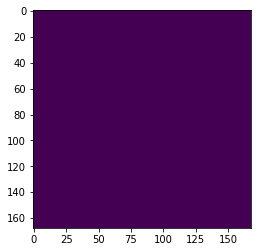

In [32]:
plt.imshow(b2_np[2, 0])

In [8]:
learn = Learner(
    data_bunch,
    classifier,
    loss_func=Loss_combine(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(), Metric_tot()]
)

logger = CSVLogger(learn, 'ComplexStn_Size160_Augs')

learn.clip_grad = 1.0
# learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()

In [9]:
learn.fit_one_cycle(
    32,
    #max_lr=slice(0.2e-2, 1e-2),
    max_lr=3e-4,
    wd=0.1e-1,
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn, monitor='metric_tot', mode='max', name='ComplexStn_Size160_Augs')]
)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/yuan/miniconda3/envs/ML/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


KeyboardInterrupt: 